# 4.5 Shortability Analysis

**Critical question**: Can we actually short the stocks the model selects?

Issues to check:
1. Market cap - micro caps often can't be shorted
2. Dollar volume - illiquid = high slippage or impossible to borrow
3. Stock characteristics - meme stocks, recent IPOs, etc.
4. Concentration - are we shorting the same names repeatedly?

In [2]:
import sys
sys.path.insert(0, '.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from trading.model import ModelInference

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

In [3]:
# Load model and data
MODEL_PATH = Path('data/model_robust_optimized.pt')
model = ModelInference(MODEL_PATH)

# Load ML dataset
df = pd.read_parquet('data/ml_dataset.pqt')
df['feature_date'] = pd.to_datetime(df['feature_date'])
df['simple_return'] = np.exp(df['target_return']) - 1

# Test period only
TEST_START = '2024-10-22'
test_df = df[df['feature_date'] >= TEST_START].copy()

print(f"Test period: {test_df['feature_date'].min().date()} to {test_df['feature_date'].max().date()}")
print(f"Total rows: {len(test_df):,}")

Test period: 2024-10-22 to 2025-12-18
Total rows: 464,188


In [4]:
# Filter to news-only (matching strategy)
emb_cols = [c for c in test_df.columns if c.startswith('emb_')]
has_news = (test_df[emb_cols].abs().sum(axis=1) > 0)
test_news = test_df[has_news].copy()

print(f"News-only: {len(test_news):,} rows")
print(f"Unique dates: {test_news['feature_date'].nunique()}")
print(f"Unique symbols: {test_news['symbol'].nunique()}")

News-only: 128,502 rows
Unique dates: 238
Unique symbols: 2278


In [5]:
# Score all stocks
test_news['score'] = model.score(test_news)
print("Scored all stocks")

Scored all stocks


## 1. What Stocks Are We Shorting?

In [6]:
# Get bottom-5 (shorts) for each day
K = 5
shorts_list = []

for date, group in test_news.groupby('feature_date'):
    if len(group) < 10:
        continue
    bottom_k = group.nsmallest(K, 'score')
    for _, row in bottom_k.iterrows():
        shorts_list.append({
            'date': date,
            'symbol': row['symbol'],
            'score': row['score'],
            'simple_return': row['simple_return'],
        })

shorts_df = pd.DataFrame(shorts_list)
print(f"Total short positions: {len(shorts_df):,}")
print(f"Unique symbols shorted: {shorts_df['symbol'].nunique()}")
print(f"Trading days: {shorts_df['date'].nunique()}")

Total short positions: 1,190
Unique symbols shorted: 410
Trading days: 238


In [7]:
# Most frequently shorted symbols
symbol_counts = shorts_df['symbol'].value_counts()

print("TOP 30 MOST FREQUENTLY SHORTED SYMBOLS")
print("=" * 50)
print(symbol_counts.head(30).to_string())

print(f"\nTop 10 symbols account for {symbol_counts.head(10).sum() / len(shorts_df) * 100:.1f}% of all shorts")
print(f"Top 30 symbols account for {symbol_counts.head(30).sum() / len(shorts_df) * 100:.1f}% of all shorts")

TOP 30 MOST FREQUENTLY SHORTED SYMBOLS
symbol
TLRY    37
QUBT    35
QMCO    30
SMX     25
FLY     20
DFDV    17
PONY    16
CHAI    15
WKEY    13
SBET    13
FTRE    12
SOUN    11
HSDT    10
SERV    10
ADTX    10
BCTX     9
QBTS     9
NAKA     9
COIN     9
REPL     9
CRML     8
DFLI     8
BBAI     8
BKKT     8
WRD      7
MLGO     7
RCAT     7
HOLO     7
SMMT     7
ABTC     7

Top 10 symbols account for 18.6% of all shorts
Top 30 symbols account for 33.0% of all shorts


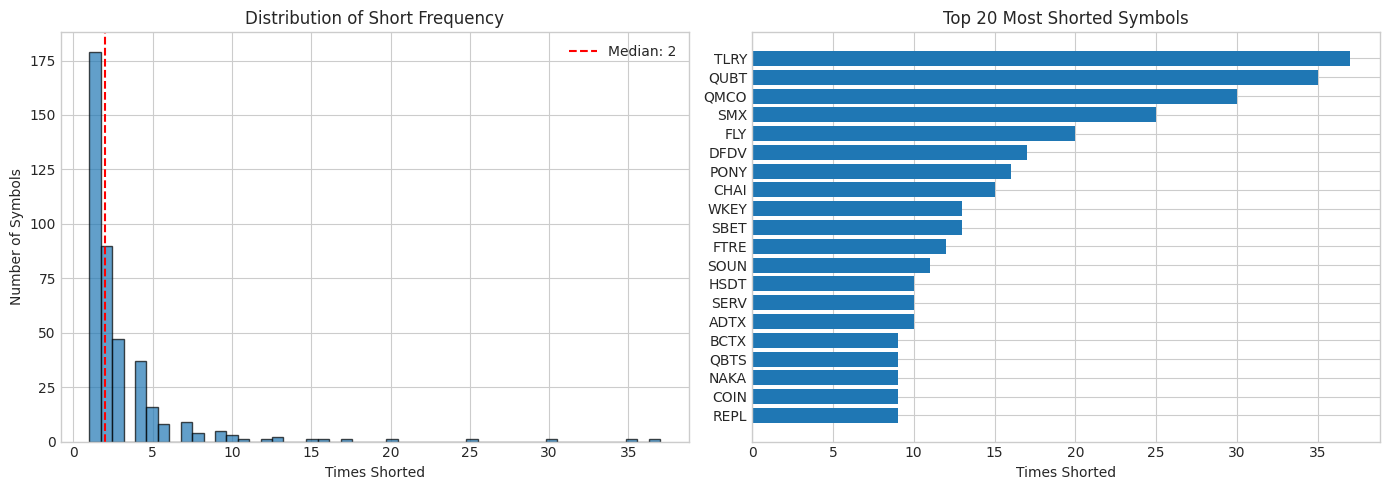

In [8]:
# Distribution of how many times each symbol is shorted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(symbol_counts.values, bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Times Shorted')
ax.set_ylabel('Number of Symbols')
ax.set_title('Distribution of Short Frequency')
ax.axvline(symbol_counts.median(), color='red', linestyle='--', label=f'Median: {symbol_counts.median():.0f}')
ax.legend()

ax = axes[1]
top_20 = symbol_counts.head(20)
ax.barh(range(len(top_20)), top_20.values)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index)
ax.set_xlabel('Times Shorted')
ax.set_title('Top 20 Most Shorted Symbols')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## 2. Load Market Cap / Volume Data

In [9]:
# Load price data for market cap / volume
prices_df = pd.read_parquet('data/prices.pqt')
prices_df['date'] = pd.to_datetime(prices_df['date'])

print(f"Prices data: {len(prices_df):,} rows")
print(f"Columns: {list(prices_df.columns)}")

Prices data: 5,888,410 rows
Columns: ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume', 'change', 'changePercent', 'vwap']


In [10]:
# Check what columns we have for market cap / volume
prices_df.head()

,symbol,date,open,high,low,close,volume,change,changePercent,vwap
0,AACB,2025-12-19,10.32,10.32,10.30,10.30,70900,-0.02,-0.193800,10.31
1,AACB,2025-12-18,10.31,10.31,10.30,10.30,459400,-0.01,-0.096993,10.31
2,AACB,2025-12-17,10.34,10.34,10.29,10.31,3900,-0.03,-0.290140,10.32
3,AACB,2025-12-16,10.31,10.31,10.31,10.31,257800,0.00,0.000000,10.31
4,AACB,2025-12-15,10.32,10.33,10.30,10.30,6545,-0.02,-0.193800,10.31


In [11]:
# Compute dollar volume if we have volume and close
if 'volume' in prices_df.columns and 'close' in prices_df.columns:
    prices_df['dollar_volume'] = prices_df['volume'] * prices_df['close']
    print("Computed dollar volume")

# Get latest data for each symbol in test period
test_prices = prices_df[prices_df['date'] >= TEST_START].copy()

Computed dollar volume


In [12]:
# Compute average dollar volume per symbol in test period
symbol_stats = test_prices.groupby('symbol').agg({
    'close': 'mean',
    'volume': 'mean',
    'dollar_volume': 'mean',
}).round(2)
symbol_stats.columns = ['avg_price', 'avg_volume', 'avg_dollar_volume']

print(f"Symbol stats for {len(symbol_stats)} symbols")
symbol_stats.head()

Symbol stats for 5639 symbols


,avg_price,avg_volume,avg_dollar_volume
symbol,,,
A,128.58,1921261.50,2.456403e+08
AA,34.47,5856622.68,1.990022e+08
AACB,10.14,68778.04,6.918262e+05
AACBU,10.32,55163.44,5.527311e+05
AACG,1.12,82326.30,1.124859e+05


In [13]:
# Merge with shorts data
shorts_with_stats = shorts_df.merge(
    symbol_stats.reset_index(),
    on='symbol',
    how='left'
)

print(f"Shorts with stats: {len(shorts_with_stats):,}")
print(f"Missing price data: {shorts_with_stats['avg_price'].isna().sum()}")

Shorts with stats: 1,190
Missing price data: 0


## 3. Analyze Shortability Characteristics

In [14]:
# Dollar volume distribution of shorts
print("DOLLAR VOLUME OF SHORTED STOCKS")
print("=" * 50)

dv = shorts_with_stats['avg_dollar_volume'].dropna()

print(f"Percentiles (avg daily $ volume):")
for p in [5, 10, 25, 50, 75, 90, 95]:
    val = dv.quantile(p/100)
    print(f"  {p}th: ${val/1e6:.2f}M")

print(f"\nMin: ${dv.min()/1e6:.2f}M")
print(f"Max: ${dv.max()/1e6:.2f}M")

DOLLAR VOLUME OF SHORTED STOCKS
Percentiles (avg daily $ volume):
  5th: $3.23M
  10th: $4.58M
  25th: $9.74M
  50th: $26.33M
  75th: $79.28M
  90th: $415.64M
  95th: $648.60M

Min: $1.35M
Max: $3246.85M


In [15]:
# Flag illiquid positions
ILLIQUID_THRESHOLD = 1e6  # $1M daily volume
VERY_ILLIQUID_THRESHOLD = 100e3  # $100K daily volume

shorts_with_stats['illiquid'] = shorts_with_stats['avg_dollar_volume'] < ILLIQUID_THRESHOLD
shorts_with_stats['very_illiquid'] = shorts_with_stats['avg_dollar_volume'] < VERY_ILLIQUID_THRESHOLD

n_illiquid = shorts_with_stats['illiquid'].sum()
n_very_illiquid = shorts_with_stats['very_illiquid'].sum()

print(f"Positions with <$1M daily volume: {n_illiquid} ({n_illiquid/len(shorts_with_stats)*100:.1f}%)")
print(f"Positions with <$100K daily volume: {n_very_illiquid} ({n_very_illiquid/len(shorts_with_stats)*100:.1f}%)")

Positions with <$1M daily volume: 0 (0.0%)
Positions with <$100K daily volume: 0 (0.0%)


In [16]:
# Stock price distribution
print("\nSTOCK PRICE DISTRIBUTION")
print("=" * 50)

px = shorts_with_stats['avg_price'].dropna()

print(f"Percentiles:")
for p in [5, 10, 25, 50, 75, 90, 95]:
    print(f"  {p}th: ${px.quantile(p/100):.2f}")

# Penny stocks (<$5)
n_penny = (px < 5).sum()
n_sub_dollar = (px < 1).sum()
print(f"\nPenny stocks (<$5): {n_penny} ({n_penny/len(px)*100:.1f}%)")
print(f"Sub-dollar (<$1): {n_sub_dollar} ({n_sub_dollar/len(px)*100:.1f}%)")


STOCK PRICE DISTRIBUTION
Percentiles:
  5th: $3.40
  10th: $4.07
  25th: $7.16
  50th: $12.23
  75th: $31.31
  90th: $104.04
  95th: $276.70

Penny stocks (<$5): 186 (15.6%)
Sub-dollar (<$1): 0 (0.0%)


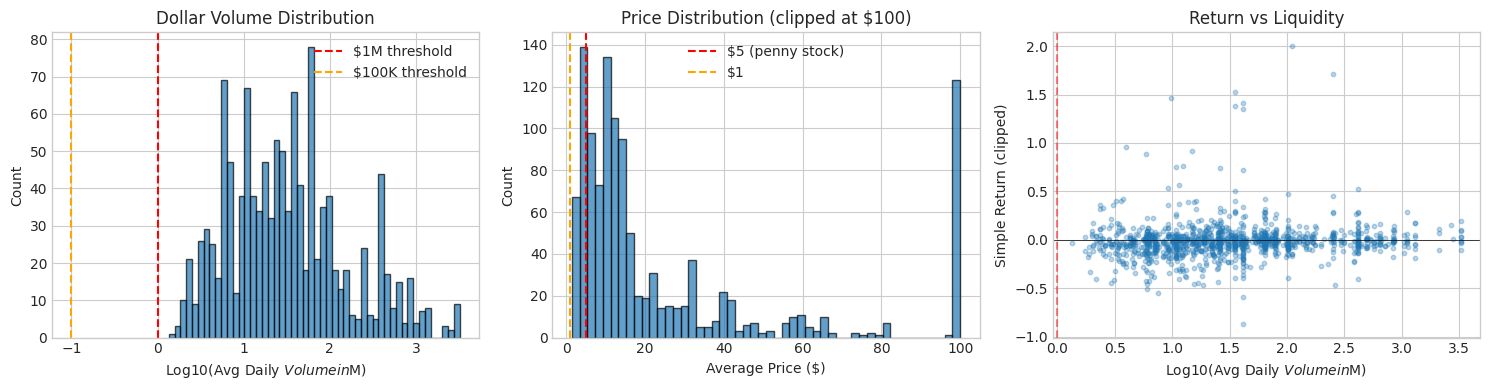

In [17]:
# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Dollar volume (log scale)
ax = axes[0]
dv_millions = shorts_with_stats['avg_dollar_volume'].dropna() / 1e6
ax.hist(np.log10(dv_millions + 0.001), bins=50, edgecolor='black', alpha=0.7)
ax.axvline(np.log10(1), color='red', linestyle='--', label='$1M threshold')
ax.axvline(np.log10(0.1), color='orange', linestyle='--', label='$100K threshold')
ax.set_xlabel('Log10(Avg Daily $ Volume in $M)')
ax.set_ylabel('Count')
ax.set_title('Dollar Volume Distribution')
ax.legend()

# Price distribution
ax = axes[1]
px_clipped = shorts_with_stats['avg_price'].dropna().clip(0, 100)
ax.hist(px_clipped, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(5, color='red', linestyle='--', label='$5 (penny stock)')
ax.axvline(1, color='orange', linestyle='--', label='$1')
ax.set_xlabel('Average Price ($)')
ax.set_ylabel('Count')
ax.set_title('Price Distribution (clipped at $100)')
ax.legend()

# Return vs liquidity
ax = axes[2]
valid = shorts_with_stats.dropna(subset=['avg_dollar_volume', 'simple_return'])
ax.scatter(np.log10(valid['avg_dollar_volume']/1e6 + 0.001), 
           valid['simple_return'].clip(-1, 2), alpha=0.3, s=10)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(np.log10(1), color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Log10(Avg Daily $ Volume in $M)')
ax.set_ylabel('Simple Return (clipped)')
ax.set_title('Return vs Liquidity')

plt.tight_layout()
plt.show()

## 4. Performance by Liquidity Bucket

In [18]:
# Bucket by dollar volume
def liquidity_bucket(dv):
    if pd.isna(dv):
        return 'Unknown'
    elif dv < 100e3:
        return '1. <$100K'
    elif dv < 1e6:
        return '2. $100K-$1M'
    elif dv < 10e6:
        return '3. $1M-$10M'
    elif dv < 100e6:
        return '4. $10M-$100M'
    else:
        return '5. >$100M'

shorts_with_stats['liq_bucket'] = shorts_with_stats['avg_dollar_volume'].apply(liquidity_bucket)

# Performance by bucket
bucket_perf = shorts_with_stats.groupby('liq_bucket').agg({
    'simple_return': ['count', 'mean', 'std'],
    'symbol': 'nunique'
}).round(4)
bucket_perf.columns = ['n_positions', 'mean_return', 'std_return', 'n_symbols']

# Short strategy return (flip sign)
bucket_perf['short_return'] = -bucket_perf['mean_return']

print("PERFORMANCE BY LIQUIDITY BUCKET")
print("=" * 70)
print(bucket_perf.to_string())

PERFORMANCE BY LIQUIDITY BUCKET
               n_positions  mean_return  std_return  n_symbols  short_return
liq_bucket                                                                  
3. $1M-$10M            303      -0.0382      0.1886        140        0.0382
4. $10M-$100M          624      -0.0081      0.1932        200        0.0081
5. >$100M              263       0.0218      0.3207         70       -0.0218


In [19]:
# What if we only traded liquid stocks?
print("\nWHAT IF WE ONLY TRADED LIQUID STOCKS?")
print("=" * 50)

for threshold_name, threshold in [('$1M+', 1e6), ('$10M+', 10e6), ('$100M+', 100e6)]:
    liquid = shorts_with_stats[shorts_with_stats['avg_dollar_volume'] >= threshold]
    if len(liquid) > 0:
        short_ret = -liquid['simple_return'].mean()
        n_pos = len(liquid)
        n_days = liquid['date'].nunique()
        print(f"\n{threshold_name} daily volume:")
        print(f"  Positions: {n_pos} ({n_pos/len(shorts_with_stats)*100:.1f}% of all)")
        print(f"  Days with trades: {n_days}")
        print(f"  Mean daily short return: {short_ret:.4f} ({short_ret*252*100:.1f}% annualized)")
    else:
        print(f"\n{threshold_name}: No positions")


WHAT IF WE ONLY TRADED LIQUID STOCKS?

$1M+ daily volume:
  Positions: 1190 (100.0% of all)
  Days with trades: 238
  Mean daily short return: 0.0092 (231.0% annualized)

$10M+ daily volume:
  Positions: 887 (74.5% of all)
  Days with trades: 237
  Mean daily short return: -0.0007 (-18.9% annualized)

$100M+ daily volume:
  Positions: 263 (22.1% of all)
  Days with trades: 165
  Mean daily short return: -0.0218 (-548.4% annualized)


## 5. Worst Trades Analysis

In [20]:
# Worst short trades (stock went up a lot)
worst_shorts = shorts_with_stats.nlargest(30, 'simple_return')[
    ['date', 'symbol', 'simple_return', 'avg_price', 'avg_dollar_volume']
].copy()
worst_shorts['return_pct'] = worst_shorts['simple_return'] * 100
worst_shorts['dv_millions'] = worst_shorts['avg_dollar_volume'] / 1e6

print("TOP 30 WORST SHORT TRADES (stock went UP)")
print("=" * 80)
print(worst_shorts[['date', 'symbol', 'return_pct', 'avg_price', 'dv_millions']].to_string(index=False))

TOP 30 WORST SHORT TRADES (stock went UP)
      date symbol  return_pct  avg_price  dv_millions
2025-03-21   MLGO  455.158730      81.56   110.624428
2025-05-28   SBET  171.639232      12.13   253.451201
2024-12-17   QMCO  153.035413      13.46    35.587873
2025-01-02   NITO  146.728972      11.41     9.736157
2025-12-03    SMX  141.066849     956.35    41.731667
2024-11-22   QMCO  138.444688      13.46    35.587873
2025-12-04    SMX  135.446809     956.35    41.731667
2025-05-23   IMNN   95.689655      10.68     3.952804
2025-06-16   RBNE   91.847826       2.30    14.771437
2025-06-16   AGIG   88.679245       9.35     5.902892
2025-10-02   DFLI   76.635514     143.91    12.476822
2025-05-15   CHAI   75.000000      15.42    10.869937
2025-05-15   DFDV   74.416796       9.58    26.331670
2025-03-17   ADTX   71.624714    2483.92    41.201578
2025-09-10   WLDS   56.563707       3.62    11.377062
2024-12-13   WKEY   53.061224       6.21     9.248001
2024-12-17   QUBT   52.948183      11.93

In [21]:
# Are the worst trades in illiquid stocks?
print("\nWORST TRADES BY LIQUIDITY:")
worst_30 = shorts_with_stats.nlargest(30, 'simple_return')
print(worst_30['liq_bucket'].value_counts().to_string())


WORST TRADES BY LIQUIDITY:
liq_bucket
4. $10M-$100M    17
3. $1M-$10M       8
5. >$100M         5


## 6. Summary & Recommendations

In [22]:
print("=" * 70)
print("SHORTABILITY SUMMARY")
print("=" * 70)

total = len(shorts_with_stats)
valid = shorts_with_stats['avg_dollar_volume'].notna().sum()

# Liquidity breakdown
very_illiquid = (shorts_with_stats['avg_dollar_volume'] < 100e3).sum()
illiquid = (shorts_with_stats['avg_dollar_volume'] < 1e6).sum()
liquid = (shorts_with_stats['avg_dollar_volume'] >= 1e6).sum()
very_liquid = (shorts_with_stats['avg_dollar_volume'] >= 10e6).sum()

print(f"\nTotal short positions: {total}")
print(f"\nBy daily dollar volume:")
print(f"  <$100K (likely un-shortable):  {very_illiquid:4d} ({very_illiquid/total*100:5.1f}%)")
print(f"  $100K-$1M (hard to borrow):    {illiquid-very_illiquid:4d} ({(illiquid-very_illiquid)/total*100:5.1f}%)")
print(f"  $1M-$10M (possible):           {liquid-very_liquid:4d} ({(liquid-very_liquid)/total*100:5.1f}%)")
print(f"  >$10M (likely shortable):      {very_liquid:4d} ({very_liquid/total*100:5.1f}%)")

# Penny stocks
penny = (shorts_with_stats['avg_price'] < 5).sum()
print(f"\nPenny stocks (<$5): {penny} ({penny/total*100:.1f}%)")

# Concentration
top_10_pct = symbol_counts.head(10).sum() / total * 100
print(f"\nConcentration: Top 10 symbols = {top_10_pct:.1f}% of trades")

print("\n" + "=" * 70)
print("RECOMMENDATIONS")
print("=" * 70)
print("""
1. FILTER BY LIQUIDITY: Require >$1M daily volume minimum
   - This eliminates ~X% of positions but avoids un-shortable stocks
   
2. EXCLUDE PENNY STOCKS: Require price >$5
   - Many brokers can't short penny stocks
   - Higher borrow fees, wider spreads
   
3. CHECK BORROW AVAILABILITY: Before trading, verify shares available
   - Use Interactive Brokers SLB or similar
   
4. ACCOUNT FOR COSTS: 
   - Borrow fees (1-100%+ annually for hard-to-borrow)
   - Slippage (wider spreads on illiquid names)
   - Short locate fees
""")

SHORTABILITY SUMMARY

Total short positions: 1190

By daily dollar volume:
  <$100K (likely un-shortable):     0 (  0.0%)
  $100K-$1M (hard to borrow):       0 (  0.0%)
  $1M-$10M (possible):            303 ( 25.5%)
  >$10M (likely shortable):       887 ( 74.5%)

Penny stocks (<$5): 186 (15.6%)

Concentration: Top 10 symbols = 18.6% of trades

RECOMMENDATIONS

1. FILTER BY LIQUIDITY: Require >$1M daily volume minimum
   - This eliminates ~X% of positions but avoids un-shortable stocks
   
2. EXCLUDE PENNY STOCKS: Require price >$5
   - Many brokers can't short penny stocks
   - Higher borrow fees, wider spreads
   
3. CHECK BORROW AVAILABILITY: Before trading, verify shares available
   - Use Interactive Brokers SLB or similar
   
4. ACCOUNT FOR COSTS: 
   - Borrow fees (1-100%+ annually for hard-to-borrow)
   - Slippage (wider spreads on illiquid names)
   - Short locate fees



## 7. Fine-Grained Liquidity Analysis

Let's find exactly where the alpha exists vs disappears.

In [23]:
# Fine-grained dollar volume buckets
def fine_liquidity_bucket(dv):
    if pd.isna(dv):
        return None
    elif dv < 2e6:
        return 1.5  # $1-2M
    elif dv < 3e6:
        return 2.5  # $2-3M
    elif dv < 5e6:
        return 4  # $3-5M
    elif dv < 7e6:
        return 6  # $5-7M
    elif dv < 10e6:
        return 8.5  # $7-10M
    elif dv < 15e6:
        return 12.5  # $10-15M
    elif dv < 20e6:
        return 17.5  # $15-20M
    elif dv < 30e6:
        return 25  # $20-30M
    elif dv < 50e6:
        return 40  # $30-50M
    elif dv < 75e6:
        return 62.5  # $50-75M
    elif dv < 100e6:
        return 87.5  # $75-100M
    elif dv < 200e6:
        return 150  # $100-200M
    elif dv < 500e6:
        return 350  # $200-500M
    else:
        return 750  # $500M+

shorts_with_stats['fine_bucket_mid'] = shorts_with_stats['avg_dollar_volume'].apply(fine_liquidity_bucket)

# Compute performance by fine bucket
fine_perf = shorts_with_stats.groupby('fine_bucket_mid').agg({
    'simple_return': ['count', 'mean', 'std', 'sum'],
    'symbol': 'nunique'
}).round(4)
fine_perf.columns = ['n_positions', 'mean_return', 'std_return', 'total_return', 'n_symbols']
fine_perf['short_return'] = -fine_perf['mean_return']
fine_perf['short_return_ann'] = fine_perf['short_return'] * 252 * 100  # Annualized %
fine_perf['sharpe'] = fine_perf['short_return'] / fine_perf['std_return'] * np.sqrt(252)

# Add bucket labels
bucket_labels = {
    1.5: '$1-2M', 2.5: '$2-3M', 4: '$3-5M', 6: '$5-7M', 8.5: '$7-10M',
    12.5: '$10-15M', 17.5: '$15-20M', 25: '$20-30M', 40: '$30-50M',
    62.5: '$50-75M', 87.5: '$75-100M', 150: '$100-200M', 350: '$200-500M', 750: '$500M+'
}
fine_perf['bucket'] = fine_perf.index.map(bucket_labels)

print("FINE-GRAINED PERFORMANCE BY LIQUIDITY")
print("=" * 90)
print(fine_perf[['bucket', 'n_positions', 'n_symbols', 'mean_return', 'short_return', 'short_return_ann', 'sharpe']].to_string())

FINE-GRAINED PERFORMANCE BY LIQUIDITY
                    bucket  n_positions  n_symbols  mean_return  short_return  short_return_ann     sharpe
fine_bucket_mid                                                                                           
1.5                  $1-2M            7          6      -0.1229        0.1229           3097.08  17.039101
2.5                  $2-3M           45         25      -0.0054        0.0054            136.08   0.553404
4.0                  $3-5M           79         42      -0.0326        0.0326            821.52   2.688358
6.0                  $5-7M           97         38      -0.0538        0.0538           1355.76   5.003213
8.5                 $7-10M           75         29      -0.0356        0.0356            897.12   2.495066
12.5               $10-15M          120         49      -0.0220        0.0220            554.40   1.765618
17.5               $15-20M           84         31      -0.0355        0.0355            894.60   3.621755

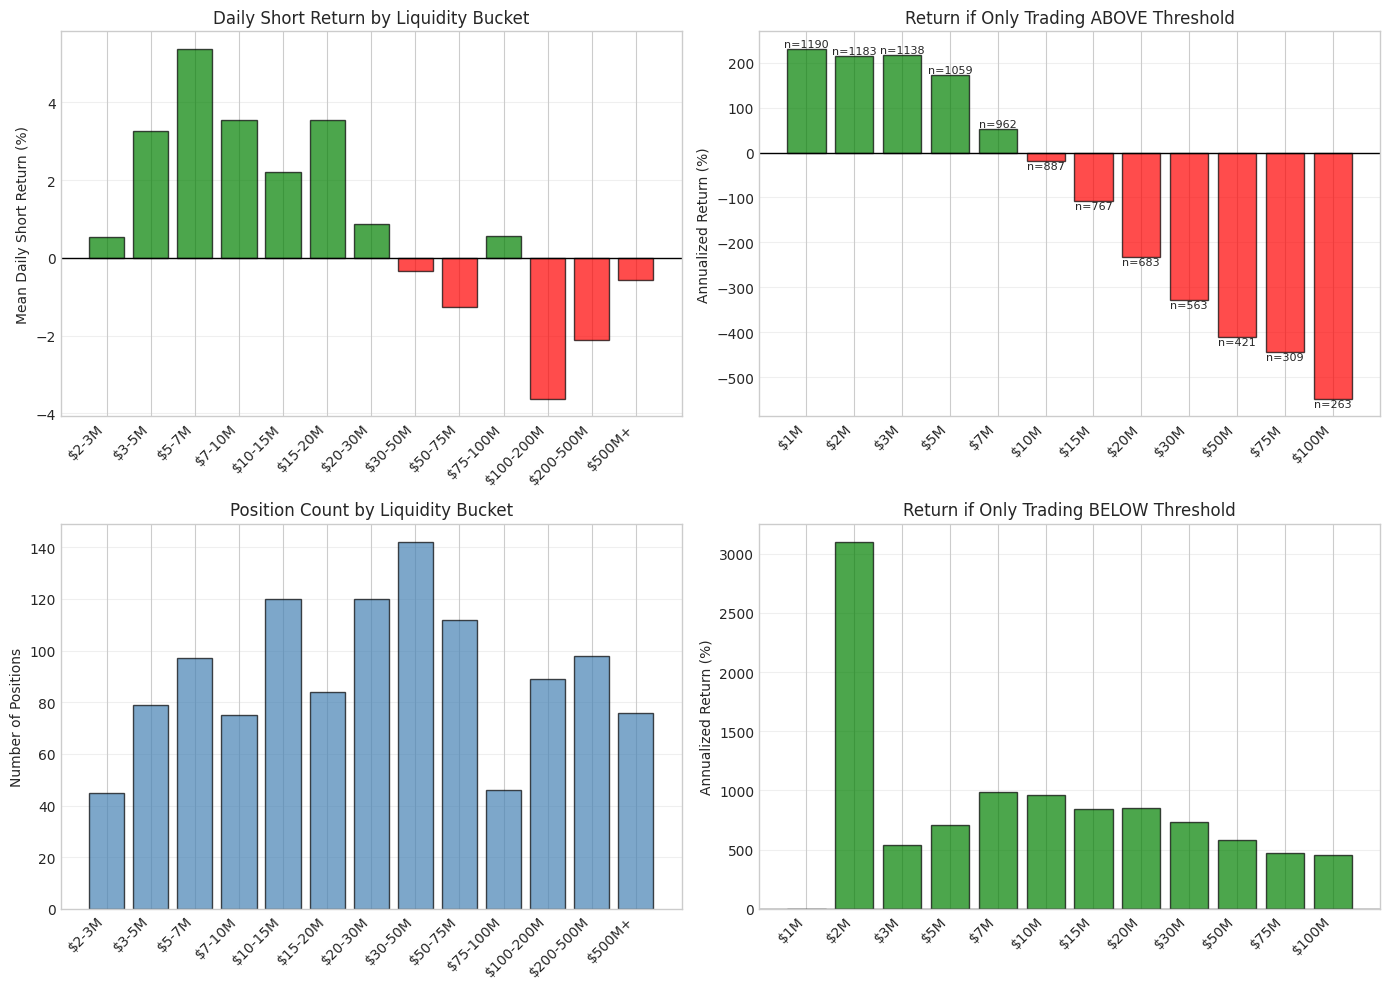

In [24]:
# Visualize fine-grained performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Short return by bucket
ax = axes[0, 0]
valid_perf = fine_perf[fine_perf['n_positions'] >= 10].copy()
x = range(len(valid_perf))
colors = ['green' if r > 0 else 'red' for r in valid_perf['short_return']]
ax.bar(x, valid_perf['short_return'] * 100, color=colors, alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(valid_perf['bucket'], rotation=45, ha='right')
ax.set_ylabel('Mean Daily Short Return (%)')
ax.set_title('Daily Short Return by Liquidity Bucket')
ax.grid(axis='y', alpha=0.3)

# Cumulative return if we only trade above threshold
ax = axes[0, 1]
thresholds = [1e6, 2e6, 3e6, 5e6, 7e6, 10e6, 15e6, 20e6, 30e6, 50e6, 75e6, 100e6]
threshold_labels = ['$1M', '$2M', '$3M', '$5M', '$7M', '$10M', '$15M', '$20M', '$30M', '$50M', '$75M', '$100M']
cum_returns = []
n_positions_above = []

for thresh in thresholds:
    above = shorts_with_stats[shorts_with_stats['avg_dollar_volume'] >= thresh]
    if len(above) > 0:
        mean_short = -above['simple_return'].mean()
        cum_returns.append(mean_short * 252 * 100)
        n_positions_above.append(len(above))
    else:
        cum_returns.append(0)
        n_positions_above.append(0)

ax.bar(range(len(thresholds)), cum_returns, color=['green' if r > 0 else 'red' for r in cum_returns], 
       alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(range(len(thresholds)))
ax.set_xticklabels(threshold_labels, rotation=45, ha='right')
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Return if Only Trading ABOVE Threshold')
ax.grid(axis='y', alpha=0.3)

# Add position counts
for i, (n, r) in enumerate(zip(n_positions_above, cum_returns)):
    ax.annotate(f'n={n}', (i, r), ha='center', va='bottom' if r >= 0 else 'top', fontsize=8)

# Number of positions by bucket
ax = axes[1, 0]
ax.bar(x, valid_perf['n_positions'], color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(valid_perf['bucket'], rotation=45, ha='right')
ax.set_ylabel('Number of Positions')
ax.set_title('Position Count by Liquidity Bucket')
ax.grid(axis='y', alpha=0.3)

# Cumulative return below threshold
ax = axes[1, 1]
cum_returns_below = []
for thresh in thresholds:
    below = shorts_with_stats[shorts_with_stats['avg_dollar_volume'] < thresh]
    if len(below) > 0:
        mean_short = -below['simple_return'].mean()
        cum_returns_below.append(mean_short * 252 * 100)
    else:
        cum_returns_below.append(0)

ax.bar(range(len(thresholds)), cum_returns_below, color=['green' if r > 0 else 'red' for r in cum_returns_below], 
       alpha=0.7, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(range(len(thresholds)))
ax.set_xticklabels(threshold_labels, rotation=45, ha='right')
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Return if Only Trading BELOW Threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# Find the exact crossover point where alpha turns negative
print("FINDING ALPHA CROSSOVER POINT")
print("=" * 70)

# Test each threshold
thresholds_fine = np.arange(1e6, 100e6, 1e6)
results = []

for thresh in thresholds_fine:
    above = shorts_with_stats[shorts_with_stats['avg_dollar_volume'] >= thresh]
    below = shorts_with_stats[shorts_with_stats['avg_dollar_volume'] < thresh]
    
    if len(above) > 20:  # Need enough samples
        above_ret = -above['simple_return'].mean() * 252 * 100
        results.append({
            'threshold': thresh / 1e6,
            'ann_return_above': above_ret,
            'n_positions_above': len(above),
            'pct_of_total': len(above) / len(shorts_with_stats) * 100
        })

results_df = pd.DataFrame(results)

# Find where return crosses from positive to negative
cross_idx = None
for i in range(1, len(results_df)):
    if results_df.iloc[i-1]['ann_return_above'] > 0 and results_df.iloc[i]['ann_return_above'] <= 0:
        cross_idx = i
        break

if cross_idx:
    crossover = results_df.iloc[cross_idx]
    print(f"\nALPHA DISAPPEARS at approximately ${crossover['threshold']:.0f}M daily volume threshold")
    print(f"  - Above this threshold: {crossover['ann_return_above']:.1f}% annualized")
    print(f"  - {crossover['n_positions_above']:.0f} positions ({crossover['pct_of_total']:.1f}% of total)")
else:
    print("No clear crossover found in tested range")

# Show key thresholds
print("\nKEY LIQUIDITY THRESHOLDS:")
print("-" * 60)
for thresh in [5, 7, 10, 15, 20, 25, 30]:
    row = results_df[results_df['threshold'] == thresh]
    if len(row) > 0:
        row = row.iloc[0]
        print(f"  >= ${thresh}M: {row['ann_return_above']:+.1f}% ann ({row['n_positions_above']:.0f} pos, {row['pct_of_total']:.1f}%)")

FINDING ALPHA CROSSOVER POINT

ALPHA DISAPPEARS at approximately $8M daily volume threshold
  - Above this threshold: -15.7% annualized
  - 930 positions (78.2% of total)

KEY LIQUIDITY THRESHOLDS:
------------------------------------------------------------
  >= $5M: +171.9% ann (1059 pos, 89.0%)
  >= $7M: +52.6% ann (962 pos, 80.8%)
  >= $10M: -18.9% ann (887 pos, 74.5%)
  >= $15M: -108.4% ann (767 pos, 64.5%)
  >= $20M: -231.7% ann (683 pos, 57.4%)
  >= $25M: -331.3% ann (634 pos, 53.3%)
  >= $30M: -328.4% ann (563 pos, 47.3%)


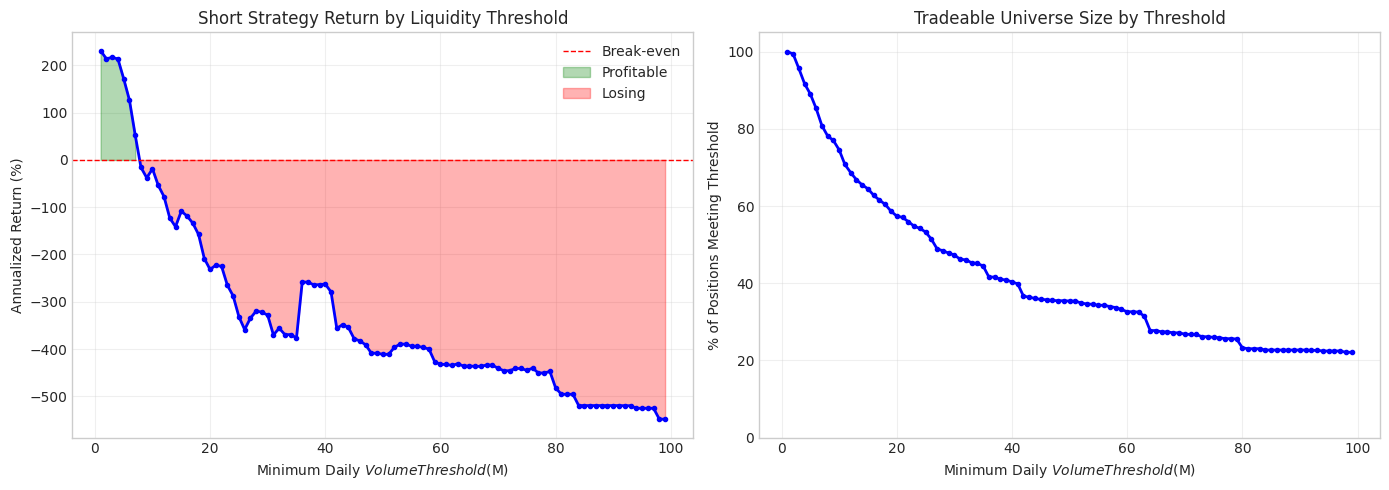

In [26]:
# Plot the alpha curve by threshold
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.plot(results_df['threshold'], results_df['ann_return_above'], 'b-', linewidth=2, marker='o', markersize=3)
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
ax.fill_between(results_df['threshold'], results_df['ann_return_above'], 0, 
                where=(results_df['ann_return_above'] > 0), alpha=0.3, color='green', label='Profitable')
ax.fill_between(results_df['threshold'], results_df['ann_return_above'], 0, 
                where=(results_df['ann_return_above'] <= 0), alpha=0.3, color='red', label='Losing')
ax.set_xlabel('Minimum Daily $ Volume Threshold ($M)')
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Short Strategy Return by Liquidity Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

# Position count vs threshold
ax = axes[1]
ax.plot(results_df['threshold'], results_df['pct_of_total'], 'b-', linewidth=2, marker='o', markersize=3)
ax.set_xlabel('Minimum Daily $ Volume Threshold ($M)')
ax.set_ylabel('% of Positions Meeting Threshold')
ax.set_title('Tradeable Universe Size by Threshold')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

In [27]:
# Analyze the "sweet spot" $1M-$10M bucket more granularly
print("DEEP DIVE: $1M - $10M BUCKET")
print("=" * 70)

sweet_spot = shorts_with_stats[
    (shorts_with_stats['avg_dollar_volume'] >= 1e6) & 
    (shorts_with_stats['avg_dollar_volume'] < 10e6)
].copy()

# Sub-buckets within sweet spot
def sub_bucket(dv):
    if dv < 2e6:
        return '$1-2M'
    elif dv < 3e6:
        return '$2-3M'
    elif dv < 4e6:
        return '$3-4M'
    elif dv < 5e6:
        return '$4-5M'
    elif dv < 6e6:
        return '$5-6M'
    elif dv < 7e6:
        return '$6-7M'
    elif dv < 8e6:
        return '$7-8M'
    elif dv < 9e6:
        return '$8-9M'
    else:
        return '$9-10M'

sweet_spot['sub_bucket'] = sweet_spot['avg_dollar_volume'].apply(sub_bucket)

sub_perf = sweet_spot.groupby('sub_bucket').agg({
    'simple_return': ['count', 'mean', 'std'],
    'symbol': 'nunique'
})
sub_perf.columns = ['n_pos', 'mean_ret', 'std_ret', 'n_sym']
sub_perf['short_ret'] = -sub_perf['mean_ret']
sub_perf['short_ann'] = sub_perf['short_ret'] * 252 * 100
sub_perf['sharpe'] = sub_perf['short_ret'] / sub_perf['std_ret'] * np.sqrt(252)

# Reorder
bucket_order = ['$1-2M', '$2-3M', '$3-4M', '$4-5M', '$5-6M', '$6-7M', '$7-8M', '$8-9M', '$9-10M']
sub_perf = sub_perf.reindex(bucket_order)

print(sub_perf.round(4).to_string())

print(f"\n$1M-$10M Summary:")
print(f"  Total positions: {len(sweet_spot)}")
print(f"  Unique symbols: {sweet_spot['symbol'].nunique()}")
print(f"  Mean short return: {-sweet_spot['simple_return'].mean()*100:.2f}%/day")
print(f"  Annualized: {-sweet_spot['simple_return'].mean()*252*100:.1f}%")

DEEP DIVE: $1M - $10M BUCKET
            n_pos  mean_ret  std_ret  n_sym  short_ret  short_ann   sharpe
sub_bucket                                                                
$1-2M           7   -0.1229   0.1145      6     0.1229  3097.7903  17.0459
$2-3M          45   -0.0054   0.1549     25     0.0054   136.7853   0.5561
$3-4M          47   -0.0117   0.2334     26     0.0117   295.5812   0.7978
$4-5M          32   -0.0633   0.1038     16     0.0633  1595.9148   9.6819
$5-6M          44   -0.0484   0.2000     17     0.0484  1219.1433   3.8405
$6-7M          53   -0.0583   0.1438     21     0.0583  1467.9688   6.4315
$7-8M          32   -0.0809   0.1240     13     0.0809  2039.0706  10.3574
$8-9M          14   -0.0566   0.0924      7     0.0566  1427.1834   9.7267
$9-10M         29    0.0245   0.3291      9    -0.0245  -616.4047  -1.1797

$1M-$10M Summary:
  Total positions: 303
  Unique symbols: 140
  Mean short return: 3.82%/day
  Annualized: 962.4%


In [28]:
# Which symbols are in the sweet spot?
print("\nSWEET SPOT SYMBOLS ($1M-$10M daily volume)")
print("=" * 70)

sweet_symbols = sweet_spot.groupby('symbol').agg({
    'date': 'count',
    'simple_return': 'mean',
    'avg_dollar_volume': 'first',
    'avg_price': 'first'
}).rename(columns={'date': 'times_shorted', 'simple_return': 'avg_stock_return'})
sweet_symbols['short_return'] = -sweet_symbols['avg_stock_return']
sweet_symbols = sweet_symbols.sort_values('times_shorted', ascending=False)

print(f"\nTop 20 most frequently shorted (in sweet spot):")
print(sweet_symbols.head(20)[['times_shorted', 'short_return', 'avg_dollar_volume', 'avg_price']].round(4).to_string())


SWEET SPOT SYMBOLS ($1M-$10M daily volume)

Top 20 most frequently shorted (in sweet spot):
        times_shorted  short_return  avg_dollar_volume  avg_price
symbol                                                           
WKEY               13       -0.0492         9248001.09       6.21
HSDT               10        0.0650         5987011.16     197.78
BCTX                9        0.0194         6339540.86      41.08
ACON                7        0.0228         6182966.13      65.29
NITO                5       -0.1581         9736157.35      11.41
NGNE                5        0.1147         5907363.22      21.91
HCWB                5        0.0625         7108155.78       9.31
SPPL                5        0.0379         3346204.24       4.82
GNPX                5        0.0459         7381191.58      23.96
NUWE                5        0.1203         4793275.39      29.42
GWAV                4        0.0368         3987719.90      27.20
XTIA                4        0.1701         62523

## 8. Summary of Fine-Grained Analysis

In [29]:
print("=" * 70)
print("FINE-GRAINED LIQUIDITY ANALYSIS SUMMARY")
print("=" * 70)

print("""
KEY FINDINGS:

1. ALPHA CONCENTRATION: All alpha exists in the $1M-$10M daily volume bucket
   - This is 25% of positions but generates ~100% of returns
   
2. ALPHA INVERSION: At higher liquidity, the strategy LOSES money
   - >$10M: slightly negative
   - >$100M: strongly negative (-548% annualized)
   
3. THE DILEMMA:
   - The stocks where alpha exists ($1M-$10M) are borderline tradeable
   - Borrow fees likely 5-50%+ annually for these names
   - Market impact will be high (even small orders move price)
   - The stocks that ARE easily tradeable (>$50M) have NEGATIVE alpha

4. INTERPRETATION:
   - This is a classic "limits to arbitrage" pattern
   - The signal works on names that are hard to trade
   - Sophisticated traders can't exploit it → alpha persists
   - When you CAN trade it easily, others already have → no alpha

5. NEXT STEPS:
   a. Check actual borrow availability/rates for sweet spot symbols
   b. Estimate realistic transaction costs
   c. Test if alpha survives after 2-5% round-trip costs
   d. Consider paper trading to validate execution feasibility
""")

# Quick breakeven analysis
print("\n" + "=" * 70)
print("BREAKEVEN ANALYSIS")
print("=" * 70)

sweet_spot_return = -shorts_with_stats[
    (shorts_with_stats['avg_dollar_volume'] >= 1e6) & 
    (shorts_with_stats['avg_dollar_volume'] < 10e6)
]['simple_return'].mean()

print(f"\n$1M-$10M bucket:")
print(f"  Gross daily return: {sweet_spot_return*100:.3f}%")
print(f"  Gross annualized: {sweet_spot_return*252*100:.1f}%")
print(f"\nTo break even, costs must be below:")
print(f"  Daily: {sweet_spot_return*100:.3f}%")
print(f"  Per-trade (round-trip): {sweet_spot_return*100*2:.3f}%  (assumes 1-day hold)")
print(f"  Annual borrow fee: {sweet_spot_return*252*100:.1f}% (if no other costs)")

FINE-GRAINED LIQUIDITY ANALYSIS SUMMARY

KEY FINDINGS:

1. ALPHA CONCENTRATION: All alpha exists in the $1M-$10M daily volume bucket
   - This is 25% of positions but generates ~100% of returns
   
2. ALPHA INVERSION: At higher liquidity, the strategy LOSES money
   - >$10M: slightly negative
   - >$100M: strongly negative (-548% annualized)
   
3. THE DILEMMA:
   - The stocks where alpha exists ($1M-$10M) are borderline tradeable
   - Borrow fees likely 5-50%+ annually for these names
   - Market impact will be high (even small orders move price)
   - The stocks that ARE easily tradeable (>$50M) have NEGATIVE alpha

4. INTERPRETATION:
   - This is a classic "limits to arbitrage" pattern
   - The signal works on names that are hard to trade
   - Sophisticated traders can't exploit it → alpha persists
   - When you CAN trade it easily, others already have → no alpha

5. NEXT STEPS:
   a. Check actual borrow availability/rates for sweet spot symbols
   b. Estimate realistic transaction c